## Bigrams using neural networks

In the previous notebook we implemented a bigram model to generate names using a dataset of US first names. 
By counting the occurrences of all bigrams within the dataset, we created a probability distribution for each.
We analysed the output of the model and defined the negative log-likelihood (NLL) of our model which allowed us a way to quantify just how well our model performed. 

Similar to the previous notebook, in this one we'll implement a bigram model on the same dataset. However instead of using the occurrence counts to compute the probabilities, we'll use a neural network, our NLL function, and back propagation to *learn* the probabilities. 
While we'll see the neural network doesn't before better than the occurrence count model, it will be more generalizable and provide foundations for more complex models. 

### Recap

Let's revisit some code from the previous notebook to build the dataset and helper objects. 

In [2]:
# read training data
fp = "../.data/nlp/"
train_set = open(f'{fp}training_corpus.txt', 'r').read().splitlines()
valid_set = open(f'{fp}validation_corpus.txt', 'r').read().splitlines()
# import libaries
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# string of all 26 characters sorted a to z. Works as all characters appear in training set.
chars = sorted(list(set(''.join(train_set))))
# mapping of characters to index.
idx_to_char = {}
char_to_idx = {}
char_to_idx['.'] = 0
for i,c in enumerate(chars):
    char_to_idx[c] = i+1
# create reverse mapping for use when plotting. 
idx_to_char = {i:c for c,i in char_to_idx.items()}

### Supervised learning and network architecture

We would like to learn the probabilities for our bigrams, given our dataset.
That is, for a bigram `XY` within our dataset, we would like `P(X|Y)` to be high if this bigram occurs often, 
and low if it does not. 
We can treat the learning of these probabilities as a supervised learning task by creating pairs of inputs and outputs (labels)
where the first half of each bigram is the input and the output is the second half.

We'll use a simple, two layer network. 
The first layer will correspond to our bigram inputs and the second layer will represent our bigram probabilities. 
The two layers will be fully connected.But how do we present our bigram characters as input? 

Recall we have 27 characters within our alphabet. We can represent our inputs using a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) vector.
A one-hote vector is a vector that is all 0s except at the ith index which is one. 
This indicates that the vector represents the ith character in our language. 

As output for our model, recall we would like a probability distribution over all possible 27 characters that can end the bigram. 
In the previous notebook we normalized the occurrence counts by dividing each count by the sum of all counts. 
We can do something similar, but remember that the outputs of the second layer can be any real number (positive or negative.)
To ensure we have a probability distribution, for each output we'll exponentiate it, the divide by the sum of all exponentiations. 
This will ensure that all outputs sum to one and is known as **softmax**.

What's helpful is to think through the shape of our two layers. 
Suppose we had $n$ bigrams in our training data. 
We can stack these all together in a single $(n \times 27)$ matrix. 
Since our two layers are fully connected and we'd like a probability for each bigram input, our second layer can be presented by a $(27 \times 27)$ matrix, with the product of these two matrices being of size $(n \times 27) (27 \times 27) = (n \times 27)$.
This makes sense as each row of this matrix (the first character of the bigram) will have 27 values - each being a probability of what the following character of the bigram should be.

Let's now begin by configuring our input and output data.

In [12]:
# create input/outputs
X, Y = [], []
for w in train_set:
    chars = ['.']+list(w)+['.']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        X.append(idx0)
        Y.append(idx1)
# convert to tensors
xs = torch.tensor(X)
ys = torch.tensor(Y)
n = xs.nelement()

Input encoding shape: torch.Size([204695, 27])


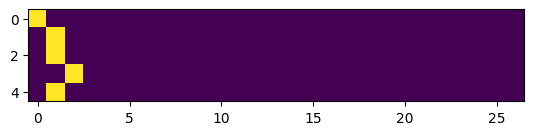

In [13]:
# use one-hot encoding to represent out inputs.
import torch.nn.functional as F
xencode = F.one_hot(xs, num_classes=27).float()
print("Input encoding shape:", xencode.shape)
# plot one-hot encoding of some training data
plt.imshow(xencode[:5])

In [68]:
# Define network 
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(892347120)
W = torch.randn((27, 27), generator=g, requires_grad=True)

### Learning the probabilities

For each input example we apply the one-hot vector to the matrix weights via multiplication to produce *logits*.
We then exponentiate these values to convert them to probabilities.
Our goal is to update $W$ to find which weight values produce probabilities that match our training data.
But how do we do this? 

Recall in the last notebook we defined the average negative log-likelihood (NLL.) 
NLL is a differentiable function - by using it as our loss function and apply gradient descent, 
we are able to update the weights of $W$ at each step using a learning rate to minimize our lost. (Note a lot of this is handled by Pytorch via its computational graphs.)

We iteratively perform this feed forward, calculate loss, then update weights until we've learned the correct weights. 

In [78]:
# forward pass
xencode = F.one_hot(xs, num_classes=27).float()
logits = xencode @ W # predict log-counts. '@' is used by torch to indicate matrix multiplication.
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)
# compute average NLL
loss = -probs[torch.arange(n), ys].log().mean()
print(loss.item())

3.5182814598083496


In [79]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()
# Update weights
lr = 10 # learning rate
W.data += -lr * W.grad

If we run the cells in order a few times, we'll see the loss printed decreases. Pulling it all together:

In [99]:
# Define network 
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(892347120)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [100]:
iters = []
losses = []
lr = 50
for i in range(300):
    # forward pass
    xencode = F.one_hot(xs, num_classes=27).float()
    logits = xencode @ W # predict log-counts. '@' is used by torch to indicate matrix multiplication.
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)
    # compute average NLL
    loss = -probs[torch.arange(n), ys].log().mean()
    print(f"i: {i+1} loss: {loss.item()}")
    iters.append(i+1)
    losses.append(loss.item())
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    W.data += -lr * W.grad

i: 1 loss: 3.7766432762145996
i: 2 loss: 3.359241247177124
i: 3 loss: 3.120978832244873
i: 4 loss: 2.986562967300415
i: 5 loss: 2.8932530879974365
i: 6 loss: 2.824035167694092
i: 7 loss: 2.771928071975708
i: 8 loss: 2.732017993927002
i: 9 loss: 2.700836420059204
i: 10 loss: 2.6760060787200928
i: 11 loss: 2.6558732986450195
i: 12 loss: 2.639235496520996
i: 13 loss: 2.625220537185669
i: 14 loss: 2.613211154937744
i: 15 loss: 2.6027727127075195
i: 16 loss: 2.5935916900634766
i: 17 loss: 2.585435390472412
i: 18 loss: 2.578126907348633
i: 19 loss: 2.571528911590576
i: 20 loss: 2.565533399581909
i: 21 loss: 2.560054302215576
i: 22 loss: 2.5550224781036377
i: 23 loss: 2.5503809452056885
i: 24 loss: 2.546083450317383
i: 25 loss: 2.542091131210327
i: 26 loss: 2.5383706092834473
i: 27 loss: 2.5348939895629883
i: 28 loss: 2.5316381454467773
i: 29 loss: 2.5285816192626953
i: 30 loss: 2.5257058143615723
i: 31 loss: 2.522996664047241
i: 32 loss: 2.5204389095306396
i: 33 loss: 2.5180206298828125
i: 3

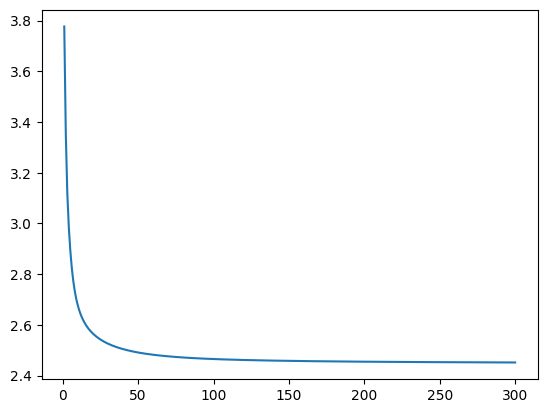

In [101]:
# Lets plot our loss per iteration below
plt.plot(iters, losses)

Finally, let's use this model to generate new names. 
Similar to last time, we start with our `.` character and use the probabilities to select the next character `x`, 
creating the bigram `.x`. We then sample the next character until we have our word. 

In [104]:
# Use a generator to sample character from a row.
g = torch.Generator().manual_seed(892347120)
# Sample 20 names from the model.
for i in range(20):
    out = []
    # start in first row
    idx = 0
    while True:
        xencode = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = xencode @ W # predict log-counts. '@' is used by torch to indicate matrix multiplication.
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item() 
        if idx == 0:
            # idx value 0 (first column) is the stoping character .
            break
        out.append(idx_to_char[idx])
    name = ''.join(out)
    print(f"Name: '{name}'. Name is in training set? {name in train_set}")

Name: 'lli'. Name is in training set? False
Name: 'ialindarie'. Name is in training set? False
Name: 'lyamio'. Name is in training set? False
Name: 'ripa'. Name is in training set? False
Name: 'domanyay'. Name is in training set? False
Name: 'erin'. Name is in training set? True
Name: 'tietorlerle'. Name is in training set? False
Name: 'dawiki'. Name is in training set? False
Name: 'nirecondela'. Name is in training set? False
Name: 'imean'. Name is in training set? False
Name: 'mmiseryo'. Name is in training set? False
Name: 'shrvalphala'. Name is in training set? False
Name: 'clhatesoleelaynosi'. Name is in training set? False
Name: 'kka'. Name is in training set? False
Name: 'yqniavoma'. Name is in training set? False
Name: 'ialeshyamietena'. Name is in training set? False
Name: 'e'. Name is in training set? False
Name: 'lesio'. Name is in training set? False
Name: 'gay'. Name is in training set? True
Name: 'sheiruiaeli'. Name is in training set? False


Hmm, very similar to our previous occurrence count model!
This is could be expected as the probabilities we're learning here are essentially the occurrence counts themselves.



### Regularization

Before finishing this notebook, we'll take a look at how we can tweak our loss function to fit our model to the training data better.
Recall in the previous notebook some bigrams did not exist within our dataset. 
Instead of allowing for a zero probability for these bigrams, we added 1 to all of our occurrence counts which gave these bigrams a non-zero probability of occurring.   
What would have happened if instead we added 1,000,000 to each bigram's occurrence count? 
The resulting distribution, while not exactly uniform, would be very close to it. 

By adding 1 to each occurrence count we **regularized** our model. 
We can do something similar to our neural net model by adding a term to our loss function changing it
$$
loss = NLL + \lambda Regularization
$$

When $\lambda = 0$ we have our NLL loss. 
Similar to how updating the occurrence counts changed our previous model's probabilities, we can use the $W$ matrix in our regularization to change the probabilities generated by our neural net. 
A common regularization term used is **L2 regularization** where L2 designates the L2 norm of the weight matrix.
By adding a regularization term, our loss function needs to balance how it updates the weights of the matrix to minimize both the NLL and Regularization terms. 

We'll implement the regularization term below, as well seeing the names our model generates as it learns:

In [113]:
# Define network 
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(892347120)
W = torch.randn((27, 27), generator=g, requires_grad=True)
iters = []
losses = []
lr = 50
for i in range(500):
    # forward pass
    xencode = F.one_hot(xs, num_classes=27).float()
    logits = xencode @ W # predict log-counts. '@' is used by torch to indicate matrix multiplication.
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)
    # compute average NLL w/ regularization
    loss = -probs[torch.arange(n), ys].log().mean() + 0.01*(W**2).mean()
    if ((i+1) % 25) == 0:
        print(f"i: {i+1} loss: {loss.item()}")
        for j in range(10):
            out = []
            # start in first row
            idx = 0
            while True:
                xencode = F.one_hot(torch.tensor([idx]), num_classes=27).float()
                logits = xencode @ W # predict log-counts. '@' is used by torch to indicate matrix multiplication.
                counts = logits.exp() # counts, equivalent to N
                probs = counts / counts.sum(1, keepdims=True)
                idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item() 
                if idx == 0:
                    # idx value 0 (first column) is the stoping character .
                    break
                out.append(idx_to_char[idx])
            name = ''.join(out)
            print(f"Name: '{name}'. Name is in training set? {name in train_set}")
    iters.append(i+1)
    losses.append(loss.item())
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    W.data += -lr * W.grad

i: 25 loss: 2.5531163215637207
Name: 'mardia'. Name is in training set? False
Name: 'aybb'. Name is in training set? False
Name: 'aelriulnielah'. Name is in training set? False
Name: 'aratieliadxray'. Name is in training set? False
Name: 'vpdri'. Name is in training set? False
Name: 'ja'. Name is in training set? True
Name: 'kxjan'. Name is in training set? False
Name: 'ken'. Name is in training set? True
Name: 'mulista'. Name is in training set? False
Name: 'h'. Name is in training set? False
i: 50 loss: 2.504810333251953
Name: 'kquzgpdro'. Name is in training set? False
Name: 'siderioryjthnasqune'. Name is in training set? False
Name: 'miata'. Name is in training set? False
Name: 'ayla'. Name is in training set? True
Name: 'ma'. Name is in training set? False
Name: 'tko'. Name is in training set? False
Name: 'lyn'. Name is in training set? True
Name: 'm'. Name is in training set? False
Name: 'kwygeman'. Name is in training set? False
Name: 'phae'. Name is in training set? False
i: 75

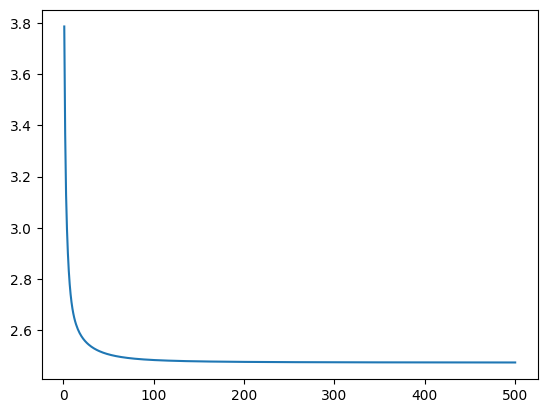

In [114]:
plt.plot(iters, losses)